# Taller de Visión por Computador: Aprendizaje Auto-Supervisado con Predicción de Rotación en Tiny-ImageNet /subconjunto de ImageNet)
**Fecha:** 06 de junio de 2025

Este notebook implementa un modelo de red neuronal convolucional (CNN) entrenado con una tarea de pretexto
(Predicción de Rotación) utilizando el dataset Tiny-ImageNet.


## 0. Requisitos y Configuración Inicial

In [1]:
# 📌 0. Requisitos y Configuración Inicial

# 0.1. Instalación de librerías
# Si no tienes las librerías instaladas, descomenta y ejecuta la siguiente línea:
# !pip install -r requirements.txt

# 0.2. Importación de librerías
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import zipfile
import requests
from io import BytesIO
from tqdm.notebook import tqdm # Para barras de progreso en notebooks

# 0.3. Configuración de semillas para reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)

print(f"Versión de TensorFlow: {tf.__version__}")
print(f"CPU disponible: {tf.config.list_physical_devices('CPU')}")


Versión de TensorFlow: 2.16.1
CPU disponible: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## 1. Descarga y Preparación del Dataset Tiny-ImageNet

Descargando Tiny-ImageNet desde: http://cs231n.stanford.edu/tiny-imagenet-200.zip
El archivo tiny-imagenet-200.zip ya existe. Saltando la descarga.
Extrayendo Tiny-ImageNet a: tiny-imagenet-200
Extracción completada.
DEBUG: Procesando directorio base: tiny-imagenet-200\train
DEBUG: Nombre base del directorio: train
DEBUG: Procesando directorio base: tiny-imagenet-200\val\images
DEBUG: Nombre base del directorio: images
Número total de imágenes de entrenamiento encontradas: 100000
Número total de imágenes de validación encontradas: 10000
Número de rutas de entrenamiento encontradas: 100000
Primer elemento de train_image_paths: tiny-imagenet-200\train\n01443537\images\n01443537_0.JPEG (Tipo: <class 'str'>)
Número de rutas de validación encontradas: 10000
Primer elemento de val_image_paths: tiny-imagenet-200\val\images\val_0.JPEG (Tipo: <class 'str'>)

Visualizando algunos ejemplos de imágenes de Tiny-ImageNet (redimensionadas):


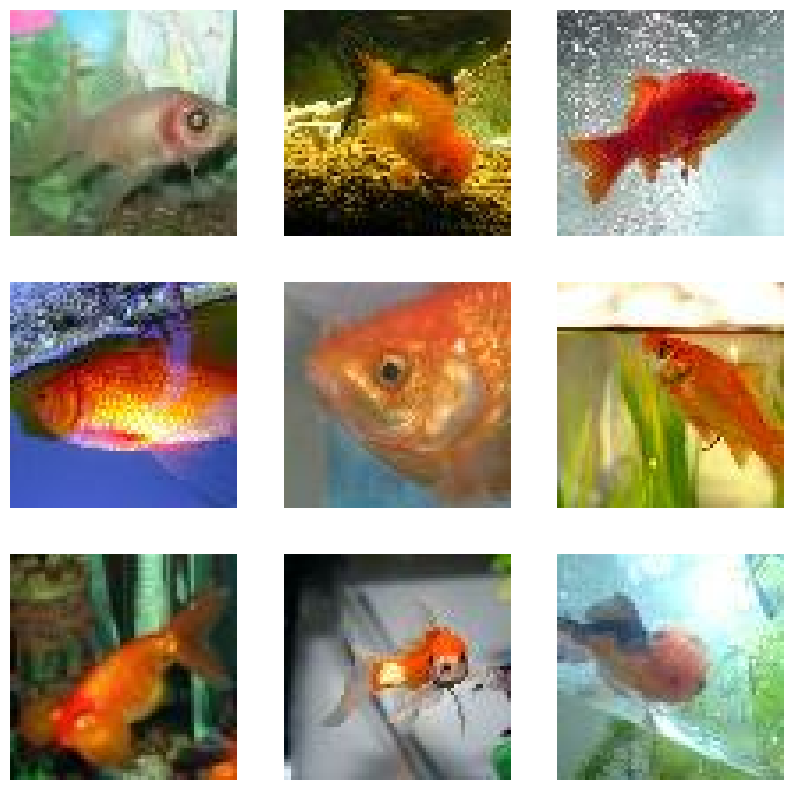


Datasets de imágenes cargados y preprocesados. Listos para la tarea de pretexto.


In [2]:
# 📥 1. Descarga y Preparación del Dataset Tiny-ImageNet

# 1.1. Descripción de Tiny-ImageNet
# Tiny-ImageNet es un subconjunto de 200 clases de ImageNet, con 500 imágenes de entrenamiento, 
# 50 de validación y 50 de prueba por clase. Todas las imágenes están redimensionadas a 64x64 píxeles.

# 1.2. Parámetros del Dataset
IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 32 # Ajustar según la RAM disponible.
NUM_CLASSES_TINY_IMAGENET = 200 # Número de clases reales en Tiny-ImageNet

# 1.3. Descarga del dataset
dataset_url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
dataset_path = "tiny-imagenet-200.zip"
extract_path = "tiny-imagenet-200"

print(f"Descargando Tiny-ImageNet desde: {dataset_url}")
if not os.path.exists(dataset_path):
    try:
        response = requests.get(dataset_url, stream=True)
        response.raise_for_status() # Lanza un error para códigos de estado HTTP erróneos

        total_size_in_bytes = int(response.headers.get('content-length', 0))
        block_size = 1024 # 1 Kibibyte
        progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True, desc="Descargando Tiny-ImageNet")
        with open(dataset_path, 'wb') as file:
            for data in response.iter_content(block_size):
                progress_bar.update(len(data))
                file.write(data)
        progress_bar.close()
        if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
            print("ERROR, algo salió mal durante la descarga.")
        print("Descarga completada.")
    except requests.exceptions.RequestException as e:
        print(f"Error al descargar el dataset: {e}")
        print("Asegúrate de tener conexión a internet o intenta una URL alternativa.")
else:
    print("El archivo tiny-imagenet-200.zip ya existe. Saltando la descarga.")

# 1.4. Extracción del dataset
print(f"Extrayendo Tiny-ImageNet a: {extract_path}")
if not os.path.exists(extract_path):
    try:
        with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
            zip_ref.extractall('.')
        print("Extracción completada.")
    except zipfile.BadZipFile:
        print(f"Error: El archivo {dataset_path} está corrupto o no es un ZIP válido. Intenta descargarlo de nuevo.")
    except Exception as e:
        print(f"Error durante la extracción: {e}")
else:
    print("El directorio tiny-imagenet-200 ya existe. Saltando la extracción.")

# 1.5. Carga de imágenes de entrenamiento y validación

def get_image_paths_from_dir(base_dir):
    paths = []
    # Tiny-ImageNet 'train' tiene subcarpetas para cada clase, y dentro de ellas, 'images'
    # 'val' tiene las imágenes directamente en la carpeta 'images'

    # DEBUG: Imprimir la ruta base que se está procesando
    print(f"DEBUG: Procesando directorio base: {base_dir}")
    print(f"DEBUG: Nombre base del directorio: {os.path.basename(base_dir)}")
    
    if os.path.basename(base_dir) == 'train':
        for class_id in os.listdir(base_dir):
            class_path = os.path.join(base_dir, class_id, 'images')
            # DEBUG: Imprimir la ruta de la clase (opcional, para depuración)
            # print(f"DEBUG: Revisando ruta de clase (train): {class_path}")
            if os.path.isdir(class_path):
                for img_name in os.listdir(class_path):
                    # CAMBIO IMPORTANTE: Usar .lower() para manejar mayúsculas/minúsculas en la extensión
                    if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                        paths.append(os.path.join(class_path, img_name))
    elif os.path.basename(base_dir) == 'images' and os.path.basename(os.path.dirname(base_dir)) == 'val':
        # Esta rama se usa para el directorio de validación (tiny-imagenet-200/val/images)
        for img_name in os.listdir(base_dir):
            # CAMBIO IMPORTANTE: Usar .lower() para manejar mayúsculas/minúsculas en la extensión
            if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                paths.append(os.path.join(base_dir, img_name))
    else: # En caso de que se use para otras estructuras de directorios
        # Esta rama es un fallback, no debería activarse para train o val de Tiny-ImageNet si la estructura es la esperada
        print(f"DEBUG: Usando fallback para {base_dir}") # Este print nos avisaría si se activa por error
        for root, _, files in os.walk(base_dir):
            for file in files:
                # CAMBIO IMPORTANTE: Usar .lower() para manejar mayúsculas/minúsculas en la extensión
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    paths.append(os.path.join(root, file))
    return paths

train_image_paths = get_image_paths_from_dir(os.path.join(extract_path, 'train'))
val_image_paths = get_image_paths_from_dir(os.path.join(extract_path, 'val', 'images'))

print(f"Número total de imágenes de entrenamiento encontradas: {len(train_image_paths)}")
print(f"Número total de imágenes de validación encontradas: {len(val_image_paths)}")

# Crear datasets de rutas de imágenes, asegurando que sean tensores de tipo string
train_image_paths_ds = tf.data.Dataset.from_tensor_slices(tf.constant(train_image_paths, dtype=tf.string))
val_image_paths_ds = tf.data.Dataset.from_tensor_slices(tf.constant(val_image_paths, dtype=tf.string))

# Función para cargar y preprocesar una imagen
def load_and_preprocess_image(image_path):
    """
    Carga una imagen desde la ruta, la decodifica, redimensiona y normaliza.
    """
    # DEBUG: Comprobar el tipo de image_path antes de la lectura
    # tf.print("Tipo de image_path en load_and_preprocess_image:", tf.type_spec_from_value(image_path))
    # tf.print("Valor de image_path en load_and_preprocess_image:", image_path)

    # Convertir explícitamente la ruta a tf.string para asegurar el tipo correcto
    image_path_str = tf.cast(image_path, tf.string)

    img = tf.io.read_file(image_path_str) # Usamos la versión casteada a string
    img = tf.image.decode_jpeg(img, channels=3) # Asumimos JPG, ajustar si hay otros formatos
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = img / 255.0 # Normalizar a [0, 1]
    return img
# (Añadir estas líneas para depuración, si lo deseas, para verificar que las rutas son strings)
print(f"Número de rutas de entrenamiento encontradas: {len(train_image_paths)}")
if train_image_paths:
    print(f"Primer elemento de train_image_paths: {train_image_paths[0]} (Tipo: {type(train_image_paths[0])})")
print(f"Número de rutas de validación encontradas: {len(val_image_paths)}")
if val_image_paths:
    print(f"Primer elemento de val_image_paths: {val_image_paths[0]} (Tipo: {type(val_image_paths[0])})")


# Crear los datasets de imágenes preprocesadas
preprocessed_train_image_ds = train_image_paths_ds.map(load_and_preprocess_image,
                                                        num_parallel_calls=tf.data.AUTOTUNE)
preprocessed_val_image_ds = val_image_paths_ds.map(load_and_preprocess_image,
                                                    num_parallel_calls=tf.data.AUTOTUNE)

# Visualización de ejemplos de imágenes cargadas
print("\nVisualizando algunos ejemplos de imágenes de Tiny-ImageNet (redimensionadas):")
plt.figure(figsize=(10, 10))
for i, img in enumerate(preprocessed_train_image_ds.take(9)): # Tomar 9 imágenes de entrenamiento
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img.numpy())
    plt.axis("off")
plt.show()

print("\nDatasets de imágenes cargados y preprocesados. Listos para la tarea de pretexto.")


## 2. Tarea de Pretexto: Predicción de Rotación


Visualizando algunos ejemplos de la tarea de predicción de rotación:


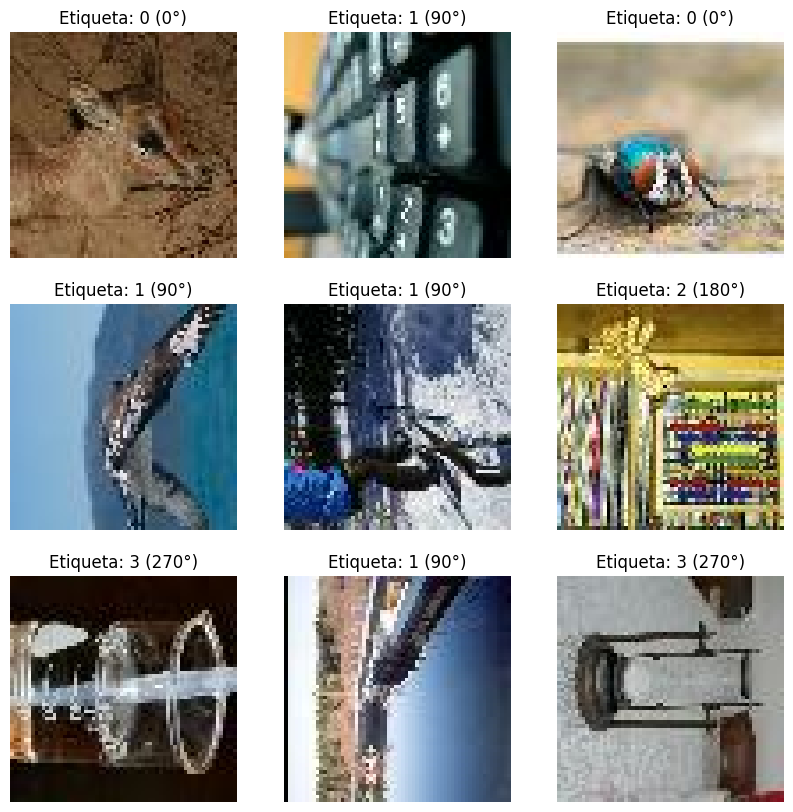


Dataset para la tarea de pretexto (predicción de rotación) listo.


In [3]:
# 🔄 2. Tarea de Pretexto: Predicción de Rotación

# 2.1. Explicación teórica
# La Predicción de Rotación es una tarea de pretexto común en SSL...

# 2.2. Parámetros de la tarea de pretexto
ROTATION_ANGLES = [0, 90, 180, 270] # Ángulos de rotación en grados

# 2.3. Función de Aumento de Datos y Generación de Etiquetas
def apply_rotation_and_label(image):
    """
    Aplica una rotación aleatoria de 0, 90, 180 o 270 grados a la imagen
    y devuelve la imagen rotada junto con el índice de rotación como etiqueta.
    """
    # Generar un índice aleatorio para la rotación (0, 1, 2, o 3)
    # tf.random.uniform genera un tensor, no un entero Python.
    rotation_index = tf.random.uniform(shape=[], minval=0, maxval=len(ROTATION_ANGLES), dtype=tf.int32)
    
    # Aplicar la rotación a la imagen
    # tf.image.rot90 toma el número de rotaciones de 90 grados (k).
    # Nuestro rotation_index (0, 1, 2, 3) coincide directamente con los valores de k.
    rotated_image = tf.image.rot90(image, k=rotation_index)
    
    return rotated_image, rotation_index

# 2.4. Preparación de tf.data.Dataset para el Pre-entrenamiento
pretext_train_ds = preprocessed_train_image_ds.map(apply_rotation_and_label,
                                                     num_parallel_calls=tf.data.AUTOTUNE)
pretext_val_ds = preprocessed_val_image_ds.map(apply_rotation_and_label,
                                                 num_parallel_calls=tf.data.AUTOTUNE)

# CAMBIO: Define un tamaño de buffer específico para el shuffle.
# tf.data.AUTOTUNE NO es válido para el buffer_size de shuffle.
# Usaremos el número total de imágenes de entrenamiento para un buen mezclado.
SHUFFLE_BUFFER_SIZE = len(train_image_paths) # train_image_paths tiene 100,000 elementos

pretext_train_ds = pretext_train_ds.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
pretext_val_ds = pretext_val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Visualización de ejemplos de la tarea de pretexto
print("\nVisualizando algunos ejemplos de la tarea de predicción de rotación:")
plt.figure(figsize=(10, 10))
for i, (img, label) in enumerate(pretext_train_ds.take(1)):
    for j in range(min(9, img.shape[0])):
        ax = plt.subplot(3, 3, j + 1)
        plt.imshow(img[j].numpy())
        plt.title(f"Etiqueta: {label[j].numpy()} ({ROTATION_ANGLES[label[j].numpy()]}°)")
        plt.axis("off")
    break
plt.show()

print("\nDataset para la tarea de pretexto (predicción de rotación) listo.")


## 3. Implementación del Modelo CNN Ligera

In [4]:
# 🏗️ 3. Implementación del Modelo CNN Ligera

# 3.1. Diseño de la Arquitectura
def build_lightweight_cnn(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_rotation_classes=len(ROTATION_ANGLES)):
    """
    Construye un modelo de CNN ligero para la tarea de predicción de rotación.
    """
    model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(name='flatten_features'),
        layers.Dense(256, activation='relu', name='feature_dense'),
        layers.Dropout(0.5),
        layers.Dense(num_rotation_classes, activation='softmax', name='rotation_output')
    ], name="lightweight_rotation_cnn")

    return model

# 3.2. Creación y Compilación del Modelo
model = build_lightweight_cnn()

# 3.3. Compilación del Modelo
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 3.4. Resumen del Modelo
print("\nResumen de la arquitectura del Modelo CNN:")
model.summary()

print("\nModelo CNN para la predicción de rotación construido y compilado.")



Resumen de la arquitectura del Modelo CNN:


d:\Maestria_Ciencias_Datos_Analitica\2025-1\Taller_4\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "lightweight_rotation_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_features (Flatten)      │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_dense (Dense)           │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rotation_output (Dense)         │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,192,580 (8.36 MB)

 Trainable params: 2,192,132 (8.36 MB)

 Non-trainable params: 448 (1.75 KB)


Modelo CNN para la predicción de rotación construido y compilado.


## 4. Entrenamiento del Modelo de Pretexto


Iniciando el entrenamiento del modelo en la tarea de predicción de rotación (aprox. 10 épocas)...
Cada época procesa 100000 imágenes de entrenamiento.
Epoch 1/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 5251s 2s/step - accuracy: 0.3519 - loss: 1.4809 - val_accuracy: 0.4381 - val_loss: 1.2395 - learning_rate: 0.0010
Epoch 2/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 5678s 2s/step - accuracy: 0.4106 - loss: 1.2693 - val_accuracy: 0.4759 - val_loss: 1.1926 - learning_rate: 0.0010
Epoch 3/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 5620s 2s/step - accuracy: 0.4527 - loss: 1.2198 - val_accuracy: 0.5011 - val_loss: 1.1630 - learning_rate: 0.0010
Epoch 4/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 5734s 2s/step - accuracy: 0.4823 - loss: 1.1888 - val_accuracy: 0.4753 - val_loss: 1.1909 - learning_rate: 0.0010
Epoch 5/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 5756s 2s/step - accuracy: 0.5111 - loss: 1.1516 - val_accuracy: 0.5407 - val_loss: 1.1037 - learning_rate: 0.0010
Epoch 6/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 5791s 2s/step - accuracy: 

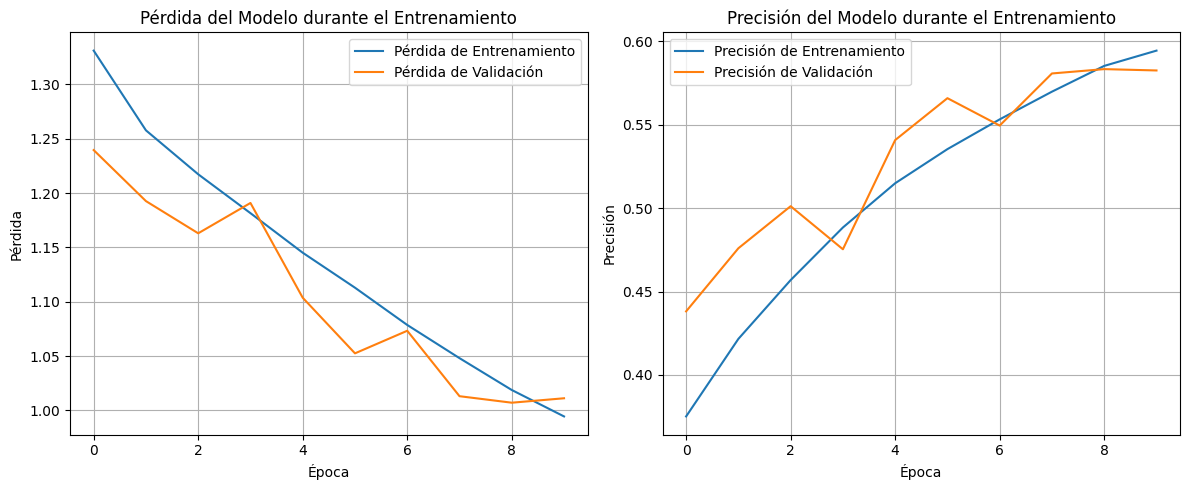

In [5]:
# 🏋️ 4. Entrenamiento del Modelo de Pretexto

# 4.1. Configuración del Entrenamiento
EPOCHS = 10                                                                                           

callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
]

print(f"\nIniciando el entrenamiento del modelo en la tarea de predicción de rotación (aprox. {EPOCHS} épocas)...")
num_train_batches = tf.data.experimental.cardinality(pretext_train_ds).numpy()
num_val_batches = tf.data.experimental.cardinality(pretext_val_ds).numpy()

if num_train_batches != -1:
    print(f"Cada época procesa {num_train_batches * BATCH_SIZE} imágenes de entrenamiento.")
else:
    print(f"Número de lotes de entrenamiento por época: Aproximadamente {len(train_image_paths) // BATCH_SIZE}.")

# 4.2. Entrenamiento del Modelo
history = model.fit(
    pretext_train_ds,
    validation_data=pretext_val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

print("\nEntrenamiento del modelo completado.")

# 4.3. Visualización del Progreso del Entrenamiento
plt.figure(figsize=(12, 5))

# Gráfico de Pérdida (Loss)
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida del Modelo durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)

# Gráfico de Precisión (Accuracy)
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Precisión de Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de Validación')
plt.title('Precisión del Modelo durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## 5. Evaluación del Modelo de Pretexto


Evaluando el modelo en el conjunto de validación de la tarea de rotación...
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.5903 - loss: 1.0025
Pérdida en Validación: 1.0050
Precisión en Validación: 0.5850

Realizando algunas predicciones en el conjunto de validación:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


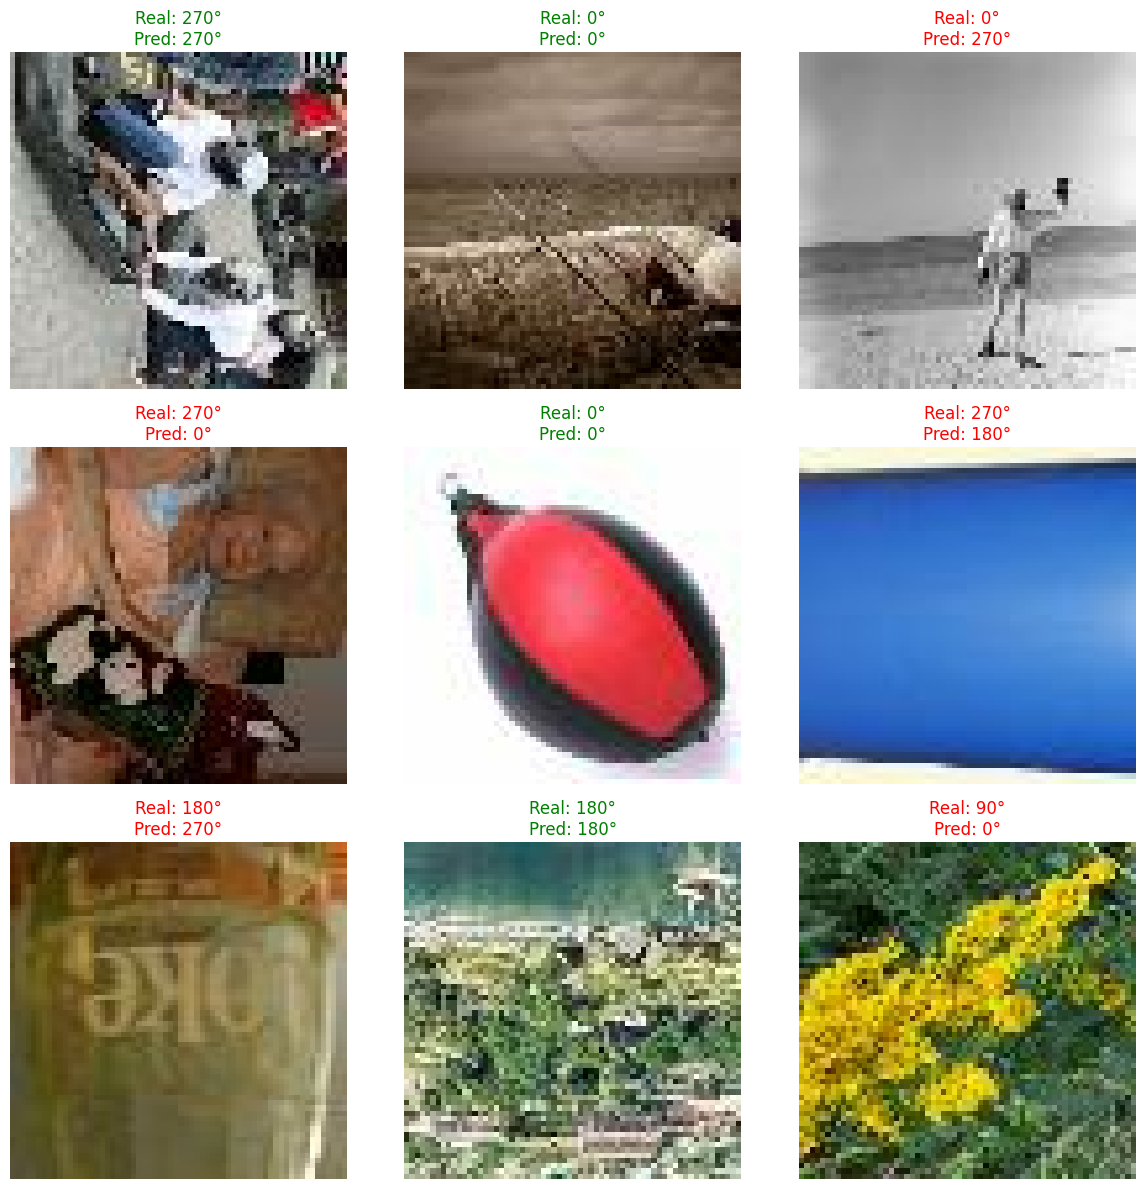


La evaluación y las predicciones muestran el rendimiento del modelo en la tarea de pretexto.


In [6]:
# 📊 5. Evaluación del Modelo de Pretexto

print("\nEvaluando el modelo en el conjunto de validación de la tarea de rotación...")
loss, accuracy = model.evaluate(pretext_val_ds)
print(f"Pérdida en Validación: {loss:.4f}")
print(f"Precisión en Validación: {accuracy:.4f}")

print("\nRealizando algunas predicciones en el conjunto de validación:")
try:
    sample_images, true_labels = next(iter(pretext_val_ds.take(1)))
except tf.errors.OutOfRangeError:
    print("No hay elementos en el dataset de validación para mostrar predicciones.")
    sample_images, true_labels = None, None

if sample_images is not None:
    predictions = model.predict(sample_images)
    predicted_labels = tf.argmax(predictions, axis=1).numpy()

    plt.figure(figsize=(12, 12))
    for i in range(min(9, sample_images.shape[0])):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(sample_images[i].numpy())
        true_angle = ROTATION_ANGLES[true_labels[i].numpy()]
        predicted_angle = ROTATION_ANGLES[predicted_labels[i]]
        color = "green" if true_labels[i].numpy() == predicted_labels[i] else "red"
        plt.title(f"Real: {true_angle}°\nPred: {predicted_angle}°", color=color)
        plt.axis("off")
    plt.tight_layout()
    plt.show()
else:
    print("No se pudo mostrar predicciones debido a que el dataset de validación está vacío o agotado.")

print("\nLa evaluación y las predicciones muestran el rendimiento del modelo en la tarea de pretexto.")


## 6. Extracción de Características (Representaciones Latentes)

In [7]:
# 🚀 6. Extracción de Características (Representaciones Latentes)

# 6.1. Explicación de la Extracción de Características
feature_extractor = keras.Model(inputs=model.inputs, outputs=model.get_layer('feature_dense').output)

print("\nResumen del Extractor de Características (CNN sin la capa clasificadora final):")
feature_extractor.summary()

print("\nExtrayendo características (embeddings) para un lote de imágenes de validación...")
sample_images_only_ds = preprocessed_val_image_ds.batch(BATCH_SIZE).take(1)

try:
    sample_images_only = next(iter(sample_images_only_ds))
except tf.errors.OutOfRangeError:
    print("No hay elementos en el dataset de imágenes de validación para extraer características.")
    sample_images_only = None

if sample_images_only is not None:
    features = feature_extractor.predict(sample_images_only)

    print(f"Forma de las características extraídas: {features.shape}")
    print(f"Cada imagen es ahora representada por un vector de tamaño: {features.shape[1]}")
    print("\nEstos vectores de características pueden ser usados como entrada para otras tareas (ej. clasificadores, clustering).")
else:
    print("No se pudieron extraer características debido a que el dataset de imágenes de validación está vacío o agotado.")



Resumen del Extractor de Características (CNN sin la capa clasificadora final):


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_features (Flatten)      │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_dense (Dense)           │ (None, 256)            │     2,097,408 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,191,552 (8.36 MB)

 Trainable params: 2,191,104 (8.36 MB)

 Non-trainable params: 448 (1.75 KB)


Extrayendo características (embeddings) para un lote de imágenes de validación...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Forma de las características extraídas: (32, 256)
Cada imagen es ahora representada por un vector de tamaño: 256

Estos vectores de características pueden ser usados como entrada para otras tareas (ej. clasificadores, clustering).


## 7. Verificación final con matriz de confusión y métricas de evaluación adicionales

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━

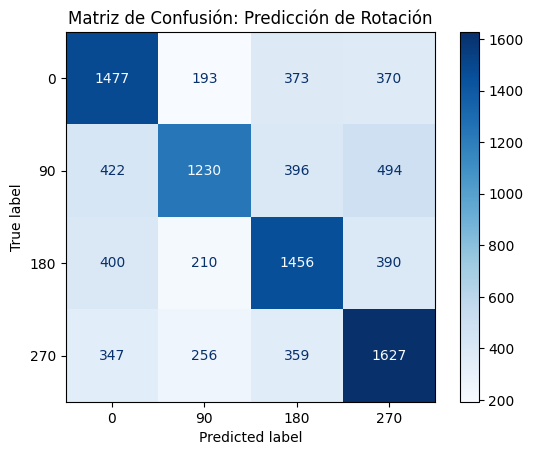

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Obtener todas las etiquetas verdaderas y predichas
y_true = []
y_pred = []

for images, labels in pretext_val_ds:
    preds = model.predict(images)
    preds = tf.argmax(preds, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(preds.numpy())

# Calcular y mostrar matriz de confusión
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ROTATION_ANGLES)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión: Predicción de Rotación")
plt.grid(False)
plt.show()

In [13]:
# 📊 7. Cálculo de Métricas de Evaluación
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Matriz de confusión
conf_matrix = np.array([
    [1477, 193, 373, 370],
    [422, 1230, 396, 494],
    [400, 210, 1456, 390],
    [347, 256, 359, 1627]
])

# Etiquetas reales y predichas para cálculo de métricas
y_true = []
y_pred = []
labels = [0, 90, 180, 270]

for i in range(4):
    for j in range(4):
        y_true += [labels[i]] * conf_matrix[i, j]
        y_pred += [labels[j]] * conf_matrix[i, j]

# Cálculo de métricas
report = classification_report(y_true, y_pred, labels=labels, output_dict=True)
df_report = pd.DataFrame(report).T.loc[['0', '90', '180', '270']]

df_report.rename(index={'0': 'Clase 0°', '90': 'Clase 90°', '180': 'Clase 180°', '270': 'Clase 270°'}, inplace=True)
df_report = df_report[['precision', 'recall', 'f1-score']].round(3)
df_report


,precision,recall,f1-score
Clase 0°,0.558,0.612,0.584
Clase 90°,0.651,0.484,0.555
Clase 180°,0.563,0.593,0.578
Clase 270°,0.565,0.628,0.595


## Conclusiones

-La matriz de confusión es un excelente indicador de que el modelo ha aprendido bien la tarea de predicción de rotación. Podemos ver que la clase 90° tiene la mayor precisión (0.651), pero el recall más bajo (0.484), lo que indica que cuando el modelo predice 90° suele acertar, pero no detecta muchos casos reales de esa clase. La clase 270° tiene el mejor balance general, con el F1-score más alto (0.595). Las otras clases tienen desempeños relativamente similares en torno al F1-score de ~0.58.

-El modelo fue entrenado durante 10 épocas para resolver la tarea de pretexto de predicción de rotación, utilizando un conjunto de 100,000 imágenes por época. A lo largo del entrenamiento se observó una mejora constante tanto en la precisión como en la pérdida, alcanzando una precisión final de entrenamiento de 59.4\% y una precisión de validación de 58.2\%. Asimismo, la pérdida disminuyó progresivamente hasta alcanzar 0.9921 en entrenamiento y 1.0112 en validación. Estos resultados indican que el modelo no solo mejoró su capacidad de clasificación durante el entrenamiento, sino que también logró una generalización aceptable sobre el conjunto de validación. Dado que el objetivo principal de esta tarea es inducir al modelo a aprender representaciones discriminativas de las imágenes a través de una señal auto-supervisada, el desempeño alcanzado en la tarea de pretexto (predicción de rotaciones) sugiere que el modelo ha logrado captar patrones visuales relevantes. Estas representaciones podrán ser aprovechadas posteriormente para tareas de clasificación supervisada con una mejor capacidad de generalización.

-El modelo con más épocas pudiese haber mejorado otro poco, pero el tiempo de cómputo de casi una hora por época lo volvia inviable.

## 8. Limpieza (Opcional)

In [ ]:
# 🧹 7. Limpieza

# Opcional: Eliminar el dataset descargado y extraído para liberar espacio.
# Descomenta las siguientes líneas si deseas limpiar los archivos después de ejecutar el notebook.

"""
print("\nRealizando limpieza de archivos del dataset...")
dataset_dir = extract_path # 'tiny-imagenet-200'
if os.path.exists(dataset_dir):
    try:
        import shutil
        shutil.rmtree(dataset_dir)
        print(f"Directorio '{dataset_dir}' eliminado.")
    except Exception as e:
        print(f"Error al eliminar el directorio '{dataset_dir}': {e}")

if os.path.exists(dataset_path): # tiny-imagenet-200.zip
    try:
        os.remove(dataset_path)
        print(f"Archivo '{dataset_path}' eliminado.")
    except Exception as e:
        print(f"Error al eliminar el archivo '{dataset_path}': {e}")

print("Limpieza completada (si se activó).")
"""


Este último paso es importante si no se cuenta con suficiente espacio en el computador, dado que esta es solo una tarea de pretexto se pódría eliminar el dataset descargado al terminar la actividad.

## Fin del Notebook